In [1]:
### Change Point Model ###
from change_detection import ChangePointDetector
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
import sys 
sys.path.append('../../../')
from main import Manager 
m = Manager('../../../')
from bin.plots.volume_oi_chart import price_volume_oi_chart

2025-04-27 20:27:04,710 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-27 20:27:04,710 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-04-27 20:27:04,713 - INFO - PriceDB Initialized successfully at 2025-04-27 20:27:04.713850
2025-04-27 20:27:04,713 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-04-27 20:27:04.713850
2025-04-27 20:27:04,714 - INFO - Established 3 database connections
2025-04-27 20:27:04,714 - bin.price.db_connect - INFO - Established 3 database connections
2025-04-27 20:27:04,788 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


ImportError: cannot import name 'plot_volume_oi_chart' from 'bin.plots.volume_oi_chart' (/Users/jerald/Documents/Dir/Python/Stocks/bin/models/trends/../../../bin/plots/volume_oi_chart.py)

In [ ]:
stock = 'gld'
column = 'total_oi'

def get_aligned(stock):
    price_df = m.Pricedb.ohlc(stock)
    price_df =price_df.resample('1D').last()
    d = m.Optionsdb.get_daily_option_stats(stock)
    d = d.resample('1D').last().tail(100)
    df = d[column].sort_index().dropna().copy()
    price_df = price_df.loc[d.index].dropna()
    d = d.loc[price_df.index].dropna()
    return price_df, d

def plot_model(stock, column):
    price_df, d = get_aligned(stock)
    df = d[column].sort_index().dropna().copy()
    detector = ChangePointDetector(df, scale=True, period=3, window_size=30)  # Adjusted window_size to 20 for better sensitivity
    # Optimized parameters
    best_params, best_result = detector.optimize_parameters(
        sensitivity_range=(0.01, 0.9, 0.01),
        threshold_range=(0.1, 2.0, 0.1), 
        min_triggers=4, 
        max_triggers=30
    )
    # print("\nBest Parameters:")
    # print(best_params)
    # print(f"Triggers: {best_result['Signal'].sum()}")

    best_params['Hits'] = best_result['Signal'].sum()

    title_text = f"{stock.upper()} {df.name} - Change Point Detection\n" \
                f"Best Parameters: {best_params}"

    fig, ax = plt.subplots(3,1, figsize=(10, 5), height_ratios=[1, 0.5, 0.5])
    ax[0].set_title(title_text)
    ax[0].plot(price_df.index, price_df['Close'], color='blue', linewidth=1, label='Price')
    ax[0].set_ylabel('Price')
    ax[0].legend()


    ax[1].plot(df.index, df.values, color='blue', linewidth=1, label = column)
    ax[2].plot(best_result.index, best_result['S_T'], linewidth=1, color='red', label='S_T')
    ax[2].hlines(best_params['threshold'], xmin=best_result.index[0], xmax=best_result.index[-1], color='green', linestyle='--', label='Threshold')

    # Scatter plot the change points
    for i in range(len(best_result)):
        if best_result['Signal'][i] == 1:
            ax[0].scatter(price_df.index[i], price_df['Close'][i], color='red', s=50, label='Change Point')
            ax[1].scatter(df.index[i], df.values[i], color='red', s=50, label='Change Point')


    fig.tight_layout()
    fig.autofmt_xdate()
    return price_df, d, best_result


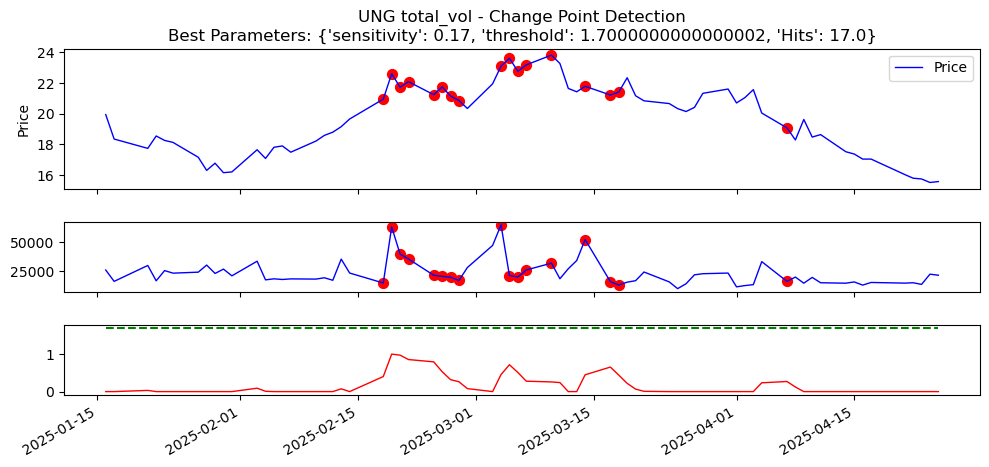

In [ ]:
# d.drop_duplicates(subset=[d.index], keep='last')
stock = 'ung'; column = 'total_vol'
res = plot_model(stock, column)

In [ ]:
res[2].iloc[-1] # If signal == 1 then there is a change point

X_MU_C        -0.0997
S_T            0.0000
Signal         0.0000
Sensitivity    0.1700
Name: 2025-04-25 00:00:00, dtype: float64

In [ ]:
from trend_results import TResults
tr = TResults(connections = '../../../',lookback_days= 45)


2025-04-27 19:38:03,783 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-27 19:38:03,784 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-04-27 19:38:03,786 - INFO - PriceDB Initialized successfully at 2025-04-27 19:38:03.786118
2025-04-27 19:38:03,786 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-04-27 19:38:03.786118
2025-04-27 19:38:03,786 - INFO - Established 3 database connections
2025-04-27 19:38:03,786 - bin.price.db_connect - INFO - Established 3 database connections
2025-04-27 19:38:03,818 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [ ]:
results = tr.analyze_stocks()

Processing nvo: 100%|██████████| 184/184 [03:57<00:00,  1.29s/it, Success=1] 


In [ ]:

results[0] + results[1]

[TrendResult(stock='gdx', name='close_prices', trend_direction='up', seasonality='low', slope=0.006751226536616128, change_point=1.0),
 TrendResult(stock='gdx', name='stock_volume', trend_direction='down', seasonality='normal', slope=0.012648369520407269, change_point=1.0),
 TrendResult(stock='gdx', name='options_volume', trend_direction='down', seasonality='normal', slope=-0.0009385191439617264, change_point=0.0),
 TrendResult(stock='gdx', name='oi', trend_direction='up', seasonality='normal', slope=-0.0008264737795331924, change_point=0.0),
 TrendResult(stock='gdx', name='atm_iv', trend_direction='up', seasonality='normal', slope=0.00013637107246190495, change_point=0.0),
 TrendResult(stock='gdx', name='call_oi', trend_direction='down', seasonality='normal', slope=-0.0008167699476000061, change_point=0.0),
 TrendResult(stock='gdx', name='put_oi', trend_direction='up', seasonality='normal', slope=-0.000849245031038194, change_point=0.0),
 TrendResult(stock='gdx', name='call_volume', t

In [ ]:
# Convert to DataFrame
data = []
for i in results:
    for result in i:
        data.append({
            'stock': result.stock,
            'metric': result.name,
            'trend_direction': result.trend_direction,
            'seasonality': result.seasonality,
            'slope': result.slope,
            'change_point': result.change_point
        })
df = pd.DataFrame(data)

# Flag slope discrepancies (where trend direction and slope sign don't match)
df['slope_discrepancy'] = ((df['trend_direction'] == 'up') & (df['slope'] < 0)) | ((df['trend_direction'] == 'down') & (df['slope'] > 0))
print("DataFrame with Slope Discrepancies Flagged:")
df[df.slope_discrepancy == True]

DataFrame with Slope Discrepancies Flagged:


,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
1,gdx,stock_volume,down,normal,0.012648,1.0,True
3,gdx,oi,up,normal,-0.000826,0.0,True
6,gdx,put_oi,up,normal,-0.000849,0.0,True
10,gme,stock_volume,down,normal,0.033623,0.0,True
19,amzn,stock_volume,down,normal,0.005194,1.0,True
...,...,...,...,...,...,...,...
1612,nke,stock_volume,down,normal,0.024542,0.0,True
1614,nke,oi,down,normal,0.000781,0.0,True
1616,nke,call_oi,down,normal,0.001646,0.0,True
1618,nke,call_volume,up,normal,-0.146497,1.0,True


In [ ]:
df[df.stock == 'intc']

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
252,intc,close_prices,down,normal,-0.003875,0.0,False
253,intc,stock_volume,down,normal,-0.004226,0.0,False
254,intc,options_volume,down,normal,-0.000741,0.0,False
255,intc,oi,down,normal,-0.000643,0.0,False
256,intc,atm_iv,up,low,0.000114,1.0,False
257,intc,call_oi,down,normal,-0.000659,0.0,False
258,intc,put_oi,down,normal,-0.000618,0.0,False
259,intc,call_volume,down,normal,-0.000687,0.0,False
260,intc,put_volume,down,normal,-0.000802,0.0,False


In [ ]:
increasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'up')].stock.tolist()
decreasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'down')].stock.tolist()

increasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price = df[(df.metric == 'price') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price = df[(df.metric == 'price') & (df.trend_direction == 'down')].stock.tolist()



In [ ]:
a = sorted(increasing_oi + increasing_price)
b = sorted(increasing_oi + decreasing_price)
print("Healthy Uptrend")
print(a)

Healthy Uptrend
['aal', 'amc', 'bito', 'bno', 'btu', 'clx', 'cmre', 'coin', 'corn', 'ctva', 'enph', 'fang', 'fcel', 'fxy', 'gdx', 'ge', 'gsl', 'icln', 'jets', 'jks', 'lc', 'mmm', 'mpw', 'nflx', 'open', 'pbw', 'pct', 'qs', 'rrc', 'snap', 'sofi', 'sol', 'sono', 'tdoc', 'tsn', 'uup', 'uwmc', 'vale', 'vuzi', 'weat', 'xlp', 'xlre']


(                  Open        High         Low       Close      Volume
 date                                                                  
 2025-01-16  137.352477  138.815263  135.770285  138.496826   4122700.0
 2025-01-17  138.964507  140.964650  138.815249  140.337738   5724500.0
 2025-01-21  144.785799  149.263711  144.288254  146.168976  11368500.0
 2025-01-22  147.154127  151.333508  146.686433  148.388031   7077700.0
 2025-01-23  148.716414  149.721466  147.681526  148.895538   4439100.0
 ...                ...         ...         ...         ...         ...
 2025-04-21  129.000000  129.839996  124.650002  126.089996   5971800.0
 2025-04-22  133.289993  137.270004  130.360001  136.330002   7943800.0
 2025-04-23  139.380005  142.149994  135.199997  136.059998   4655800.0
 2025-04-24  135.639999  139.759995  135.119995  138.880005   2920500.0
 2025-04-25  139.000000  138.990005  137.149994  138.134995   1058715.0
 
 [69 rows x 5 columns],
             total_vol    total_prem  

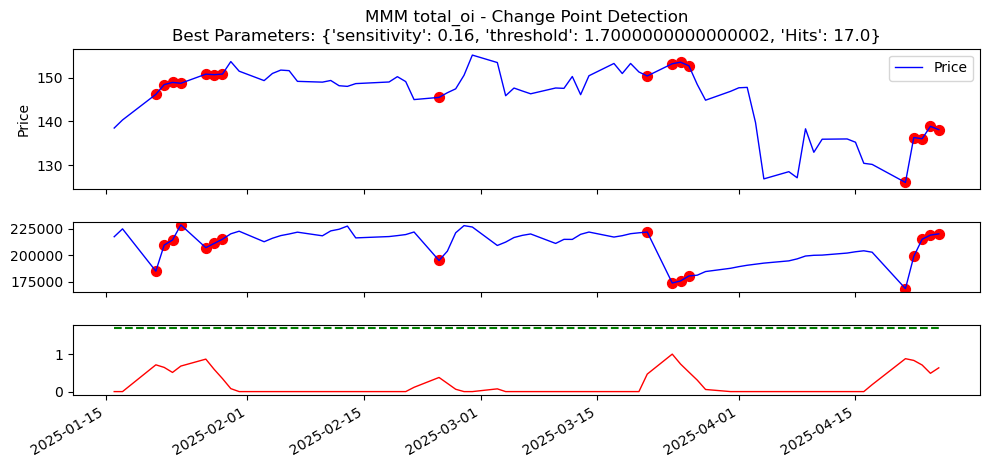

In [ ]:
plot_model('mmm', 'total_oi')

In [ ]:
b

set()

In [ ]:
df[df.stock == 'coin']

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
756,coin,close_prices,up,normal,-0.004131,1.0,True
757,coin,stock_volume,down,normal,-0.006370,0.0,False
758,coin,options_volume,up,low,-0.000596,0.0,True
759,coin,oi,up,normal,-0.000987,0.0,True
760,coin,atm_iv,up,normal,-0.000066,1.0,True
761,coin,call_oi,up,normal,-0.000737,0.0,True
762,coin,put_oi,down,normal,-0.001337,0.0,False
763,coin,call_volume,up,low,-0.000430,0.0,True
764,coin,put_volume,up,low,-0.000924,0.0,True


In [ ]:
df[df.change_point == 1]

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
0,gdx,close_prices,up,low,0.006751,1.0,False
1,gdx,stock_volume,down,normal,0.012648,1.0,True
13,gme,atm_iv,up,low,0.000261,1.0,False
18,amzn,close_prices,down,normal,-0.004358,1.0,False
19,amzn,stock_volume,down,normal,0.005194,1.0,True
...,...,...,...,...,...,...,...
1619,nke,put_volume,down,low,-0.168031,1.0,False
1620,nvo,close_prices,down,normal,-0.008836,1.0,False
1621,nvo,stock_volume,up,low,0.009463,1.0,False
1624,nvo,atm_iv,up,normal,0.536434,1.0,False


In [ ]:
df[df.stock == 'nvda']

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
936,nvda,close_prices,down,normal,-0.004116,1.0,False
937,nvda,stock_volume,down,normal,-0.005064,0.0,False
938,nvda,options_volume,down,high,-0.000209,1.0,False
939,nvda,oi,down,normal,0.000744,0.0,True
940,nvda,atm_iv,up,low,0.000043,1.0,False
941,nvda,call_oi,down,normal,0.000781,0.0,True
942,nvda,put_oi,down,normal,0.000709,0.0,True
943,nvda,call_volume,down,high,-0.000141,1.0,False
944,nvda,put_volume,down,normal,-0.000347,1.0,False


In [ ]:
df.groupby(['metric', 'seasonality']).size().unstack(fill_value=0)

seasonality,high,low,normal
metric,,,
atm_iv,12,52,117
call_oi,15,28,138
call_volume,19,32,130
close_prices,16,19,146
oi,16,25,140
options_volume,22,28,131
put_oi,15,26,140
put_volume,26,24,131
stock_volume,17,26,138
